# <center>Data Mining Project Code</center>

** **
## <center>*03 - Customer Data Segmentation*</center>

** **

In this notebook, we aim to gain insights into customer behaviors and preferences by clustering them based on their socio-demographic attributes. By segmenting customers according to factors such as region, age, and repeat purchase behavior, we tried to understand if purchase habits differ from age groups and even location areas. These insights will empower businesses to develop more targeted marketing strategies and create personalized promotions that align with the unique characteristics of each customer segment.

Given the existing data, we will use a different algorithm to segment these customers. Therefore, we will use the K-Prototypes algorithm. The number of optimal values will be based on a elbow plot and UMAP.


The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# ToC

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

2. [Clustering](#2.-Clustering) <br><br>

    2.1 [Scaling](##2.1-Scaling) <br><br>
    2.2 [K-Prototypes](##2.2-K-Prototypes) <br><br>


# 1. Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Clustering algorithms
from kmodes.kprototypes import KPrototypes

# Evaluation
import umap

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Others
import functions as f

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

path = './plots/customer_data/'

<br>

**Customer data**

In [2]:
data = pd.read_csv('data/data.csv', 
                   index_col = "customer_id")

outlier_data = pd.read_csv('data/outlier_data.csv', 
                   index_col = "customer_id")

customer_data = data[s.customer_info]

When importing the data, the feature `customer_region` was stored as integer, therefore we proceed to put it back as categorical.

In [3]:
customer_data['customer_region'] = customer_data['customer_region'].replace(0, '0000')
customer_data['customer_region'] = customer_data['customer_region'].astype(str)
customer_data['customer_region'].unique()

array(['2360', '8670', '4660', '2440', '0000', '4140', '2490', '8370',
       '8550'], dtype=object)

In [4]:
customer_data

,customer_region,customer_age,is_repeat_customer
customer_id,,,
1b8f824d5e,2360,18,1
5d272b9dcb,8670,17,1
f6d1b2ba63,4660,38,1
180c632ed8,4660,27,1
4eb37a6705,4660,20,1
...,...,...,...
f4e366c281,8670,30,0
f6b6709018,8670,26,0
f74ad8ce3f,8670,24,0


<br>

# 2. Clustering

## 2.1 Scaling

<a href="#top">Top &#129033;</a>

Before applying the K-Prototype model, we will scale the data using the Min-Max Scaler. This step is critical as it ensures that all features are normalized to a common range, improving the model's interpretability. Since the dataset is not normally distributed and outliers have already been removed, the Min-Max Scaler was chosen to rescale the features to a range of [0, 1]. This method preserves the relationships between data points without distorting the distribution of values.


In [5]:
scaler = MinMaxScaler()

For this data, we are going to consider only the feature `customer_age` given that its numerical in this dataset.

In [6]:
customer_data['customer_age'] = scaler.fit_transform(customer_data[['customer_age']])

<br>

## 2.2 K-Prototypes

<a href="#top">Top &#129033;</a>

#### UMAP Embedding

One of the comparison methods will be visual, so we need a way to visualise the quality of clustering. We will be using Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) - a dimensionality reduction technique to embedd the data into 2 dimensions. This will allow us to visually see the groups of customers, and how well did the clustering algorithms do the job. Given that we had a categorical feature, there are 3 steps to get the proper embeddings:

1. One-Hot-Encode the categorical data
2. Embed these two column data types separately
3. Combine the two by conditioning the numerical embeddings on the categorical embeddings

In [7]:
customer_data['is_repeat_customer'] = customer_data['is_repeat_customer'].replace({1: True, 0: False})

In [9]:
##preprocessing categorical
categorical_type = customer_data[['customer_region', 'is_repeat_customer']]
categorical_type = pd.get_dummies(categorical_type)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(customer_data.select_dtypes(include='object').columns) / customer_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(customer_data[['customer_age']])
fit2 = umap.UMAP(metric='hamming').fit(categorical_type)

With this we can get a first look of how the data looks like.

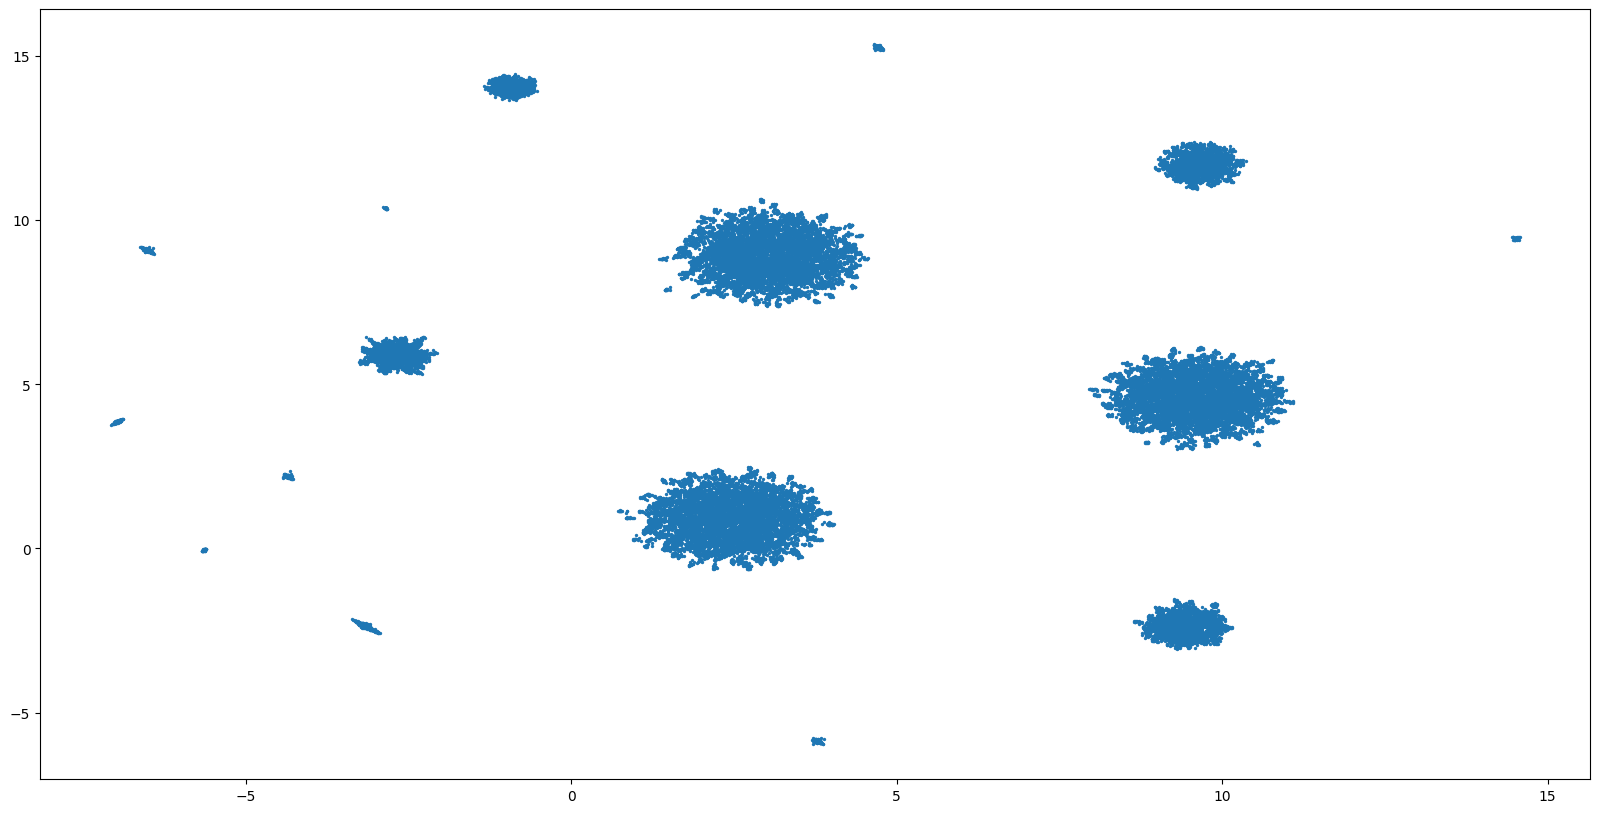

In [11]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(
    fit1._raw_data, intersection, fit1.n_components,
    fit1._initial_alpha, fit1._a, fit1._b,
    fit1.repulsion_strength, fit1.negative_sample_rate,
    400, 'random', np.random, fit1.metric,
    fit1._metric_kwds, False, {}, False
)

embedding_array = embedding[0]  

plt.figure(figsize=(20, 10))
plt.scatter(*embedding_array.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

To develop an optimal clustering solution using the K-Prototypes algorithm, the following steps were carried out:

1. **Using the Cost Attribute to Determine a Range for `n_clusters`**
   - We began by using the **cost_ attribute** of the K-Prototypes algorithm to identify an appropriate range of values for the `n_clusters` hyperparameter.
   - The **cost_ attribute** measures the dissimilarity between data points and the modes of their respective clusters, calculated using Hamming Distance for categorical features.
   - By plotting the cost for a range of values of `n_clusters`, we identified the "elbow point," where increasing the number of clusters resulted in lower improvements to the cost.
   - This step provided an initial estimate for the potential number of clusters and guided further analysis.

2. **Evaluating Different `n_clusters` Values**
   - After identifying a range for `n_clusters`, we evaluated different values of `n_clusters` based on the cost_ attribute and additional clustering evaluation criteria:
     - The overall **cluster quality**, indicated by the intra-cluster similarity. This was identified by using Umap visualization.
     - After analyzing the cost and evaluating the quality of clustering solutions for various `n_clusters` values, we selected the value that offered the best visual results.

In [12]:
def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [14]:
cat_cols = ['customer_region', 'is_repeat_customer']
categorical_indices = column_index(customer_data, cat_cols)
categorical = list(categorical_indices)

In [15]:
cost_cao = []
for cluster in range(2,11):
    try:
        model = KPrototypes(n_clusters=cluster, init="Cao", random_state=42)
        model.fit_predict(customer_data, categorical= categorical)
        cost_cao.append(model.cost_)
        print("Cluster Initiation: {}".format(cluster))
    except:
        break

Cluster Initiation: 2
Cluster Initiation: 3
Cluster Initiation: 4
Cluster Initiation: 5
Cluster Initiation: 6
Cluster Initiation: 7
Cluster Initiation: 8
Cluster Initiation: 9
Cluster Initiation: 10


In [16]:
data_cost = pd.DataFrame({"Cluster":range(2,11),"Cost":cost_cao})
data_cost

,Cluster,Cost
0,2,1389.648387
1,3,947.757982
2,4,822.801649
3,5,751.476915
4,6,697.487469
5,7,675.633828
6,8,638.035240
7,9,617.885751
8,10,491.774130


#### Elbow Plot

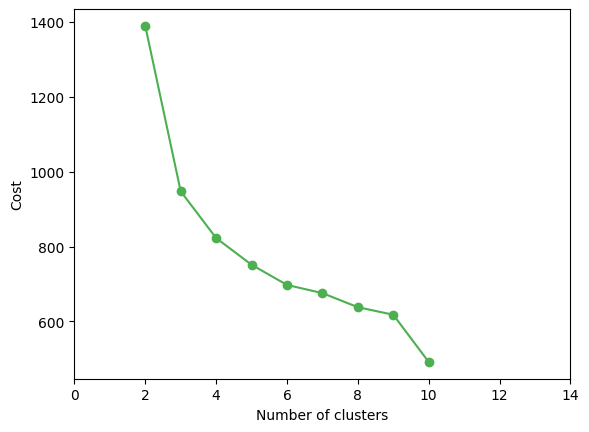

In [17]:
plt.plot(range(2, 11), cost_cao, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.xticks(np.arange(0, 16, step=2))  
plt.show()

<br>

**Final Model**

In [22]:
model_4 = KPrototypes(n_clusters= 4, init= "Cao",random_state=42)
clusters4 = model_4.fit_predict(customer_data, categorical= categorical)

<br>

#### **Visualization of clusters**

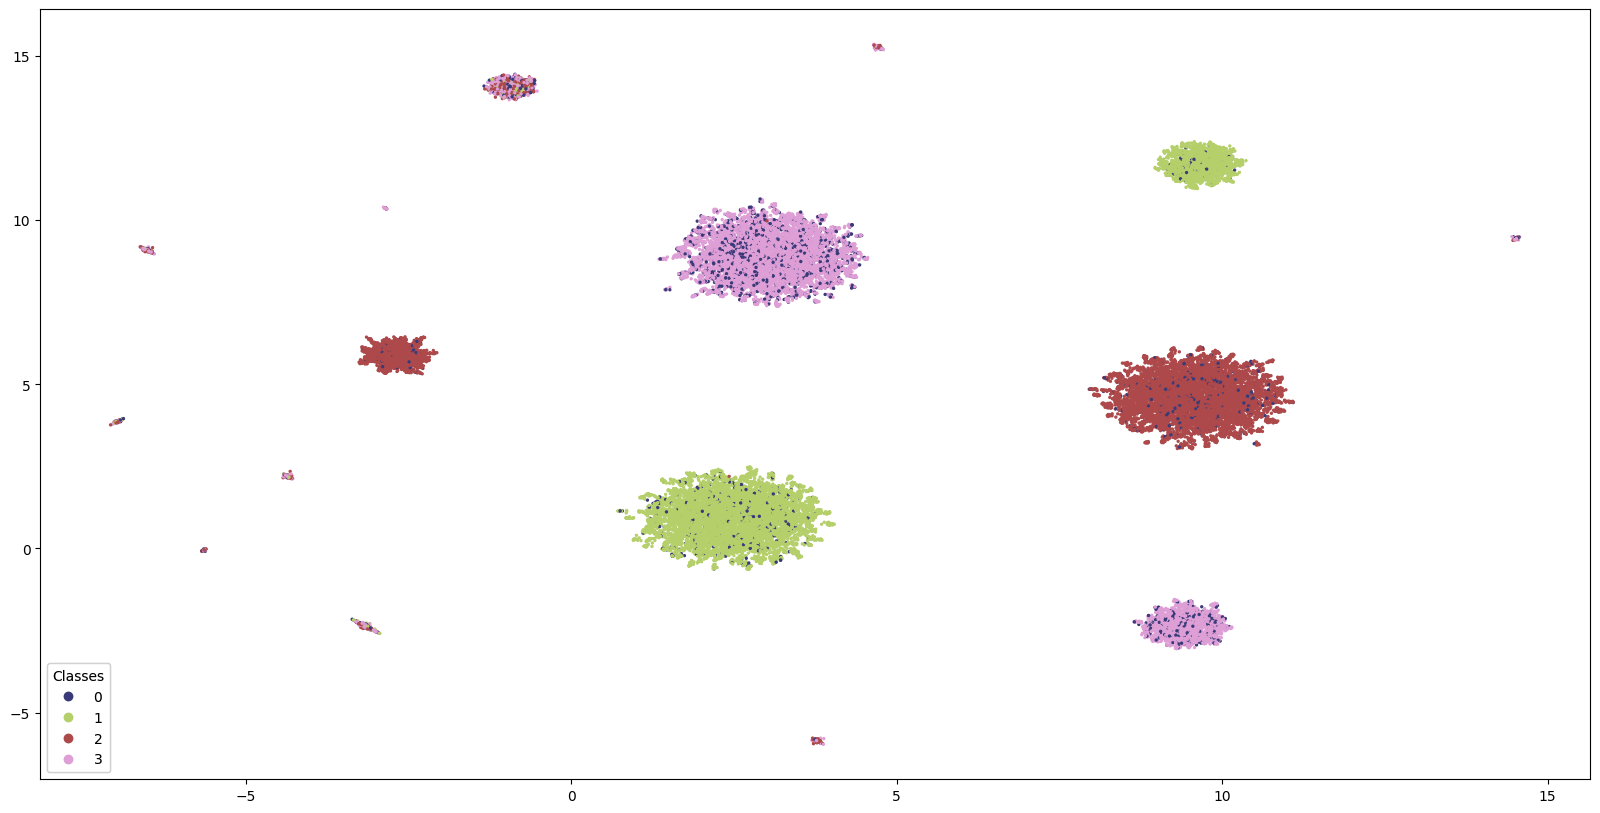

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters4, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=3),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

We applied the inverse transformation to the `customer_age` feature to get the actual age values. The scaling process transformed the data into a normalized range, but when profiling clusters, it’s important to understand the real, unscaled values to interpret the results correctly.

By reversing the scaling, we ensure that the actual age of customers is visible. This helps us understand the age distribution within each cluster, making the cluster profiling more understandable.


In [33]:
customer_data['customer_age'] = scaler.inverse_transform(customer_data[['customer_age']])

In [34]:
customer_data['customer_age'] = customer_data['customer_age'].round().astype(int)

<br>

**Cluster Profilling**

In [41]:
customer_data['is_repeat_customer'] = customer_data['is_repeat_customer'].replace({True: 1, False: 0})

In [45]:
numeric_summary = customer_data.groupby('Cluster labels 4')[['customer_age', 'is_repeat_customer']].mean()
print(numeric_summary)

                  customer_age  is_repeat_customer
Cluster labels 4                                  
0                    42.616433            0.763904
1                    26.488107            0.770882
2                    26.985042            0.795850
3                    24.601091            0.748190


In [46]:
categorical_summary = customer_data.groupby('Cluster labels 4')['customer_region'].agg(lambda x: x.mode().iloc[0])
print(categorical_summary)

Cluster labels 4
0    8670
1    4660
2    2360
3    8670
Name: customer_region, dtype: object


In [43]:
customer_data.to_csv('./data/labels/customer_data.csv')